<a href="https://colab.research.google.com/github/yuvipaloozie/The-Power-of-Smart-ML/blob/main/ArrythmiaML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ML-Driven Approach to Arrythmia Detection

Deep Learning models  are the state-of-the-art for sequence classification, often treating biological signals as "images" to be pattern-matched. However, biological systems are governed by chaos theory and homeostatic regulation.

**Hypothesis:** A lightweight classifier (Logistic Regression/SVM) using domain-specific metrics (Poincaré Plots, HRV Entropy) can achieve comparable performance to a Deep Learning model with significantly higher interpretability and lower computational cost.


### Proposed Workflow
We will benchmark two pipelines on the **MIT-BIH Arrhythmia Database**:
1.  **The DL Approach:** A 1D-Convolutional Neural Network (CNN) trained on raw voltage waveforms.
2.  **The ML + Feature Engineering Approach:** A classifier trained on R-R interval stability metrics derived from non-linear dynamics (Poincaré analysis).

### Dataset Info
* **Source:** MIT-BIH Arrhythmia Database (PhysioNet)
* **Format:** Dual-channel ECG (360 Hz) with expert annotations.

In [1]:
# @title Config and Imports
!pip install wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
from wfdb import processing
import os

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

class Config:
    # dataset config
    DB_NAME = 'mitdb'
    DL_DIR = './mitdb_data'

    FS = 360  # MIT-BIH sampling frequency is 360Hz
    WINDOW_SECONDS = 10 # 10s window analysis
    WINDOW_SIZE = FS * WINDOW_SECONDS

    # colors for visualization
    COLOR_RAW = '#2c3e50'
    COLOR_ANOMALY = '#e74c3c'
    COLOR_PEAK = '#27ae60'

print("Configuration Complete")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 153.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Configuration Complete


## Dataset and Domain Context
**Source:** MIT-BIH Arrhythmia Database (PhysioNet)             
**Sample Rate:** 360 Hz (360 samples per second)                        
**Duration:** 48 records, each 30 minutes long                            
**Annotations:** 110,000+ expert-labeled beats

ECG signals are known for being notoriously noisy, commonly affected by:
- movement spikes that cause frequency artifacts
- patient breathing that causes voltage drift
- powerline interference from electrical equipment

We are focusing on distinguishing **Normal (N)** beats from specific arrhythmias:
* **A:** Atrial Premature Beat
* **V:** Premature Ventricular Contraction
* **L/R:** Bundle Branch Blocks

In [2]:
# @title Download Complete MIT-BIH Database
def download_full_dataset():
    if not os.path.exists(Config.DL_DIR):
        os.makedirs(Config.DL_DIR)

    # Get list of all records in MIT-BIH
    print("Fetching record list.")
    records = wfdb.get_record_list(Config.DB_NAME)
    print(f"Found {len(records)} records: {records}")
    wfdb.dl_database(Config.DB_NAME, Config.DL_DIR, records)
    print("Download complete.")

    return records

all_records = download_full_dataset()

Fetching record list.
Found 48 records: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating reco

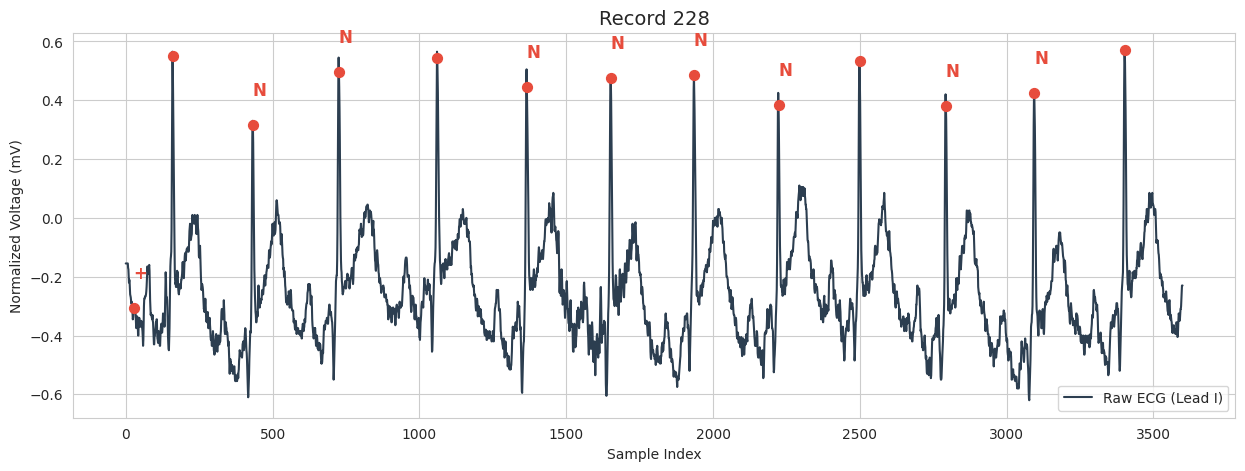

In [3]:
# @title Data Inspection: Signal & Annotations
def plot_sample_record(record_id, seconds=10):

    record_path = os.path.join(Config.DL_DIR, record_id)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')
    num_samples = seconds * Config.FS
    signal = record.p_signal[:num_samples, 0] # Lead I
    valid_indices = [i for i, samp in enumerate(annotation.sample) if samp < num_samples]
    ann_samples = [annotation.sample[i] for i in valid_indices]
    ann_symbols = [annotation.symbol[i] for i in valid_indices]

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(signal, color=Config.COLOR_RAW, label='Raw ECG (Lead I)')
    # Plot Annotations
    for samp, sym in zip(ann_samples, ann_symbols):
        plt.scatter(samp, signal[samp], c=Config.COLOR_ANOMALY, s=50, zorder=5)
        plt.annotate(sym, (samp, signal[samp] + 0.1), fontsize=12, fontweight='bold', color=Config.COLOR_ANOMALY)

    plt.title(f"Record {record_id}", fontsize=14)
    plt.xlabel("Sample Index")
    plt.ylabel("Normalized Voltage (mV)")
    plt.legend()
    plt.show()

plot_sample_record('228')

## Feature Engineering
Instead of feeding raw voltage into the model, we use **Non-Linear Dynamics** to extract the stability of the heart's control system.

### A. The Pre-processing (Bandpass Filter)
* **Problem:** Raw ECG contains noise from muscle movement (EMG) and breathing (baseline wander).
* **Solution:** We apply a **5-15Hz Bandpass Filter**.
* **Why?** The QRS complex (the main heartbeat spike) primarily consists of frequencies between 5Hz and 15Hz. This filter isolates the heart muscle's electrical firing while ignoring the patient's breathing or chest movement.

### B. The Poincaré Plot
We transform the time-series data into a "Phase Space" by plotting every R-R interval ($t_n$) against the next interval ($t_{n+1}$).
* **Normal Heart:** Produces a cigar or "comet" shape aligned with the diagonal. This shows the heart correcting itself (Homeostasis).
* **Arrhythmic Heart:** Produces a scattered cloud or complex "fan" shape. This indicates a loss of autonomic control.

### C. The Metrics (SD1 & SD2)
We quantify the shape of this plot using ellipse fitting geometry:
1.  **SD1 (Short-term Variability):**
    * The width of the ellipse perpendicular to the diagonal.
    * *Biology:* Measures rapid changes (Parasympathetic/Vagus nerve activity).
    * *Math:* Standard deviation of $\frac{RR_n - RR_{n+1}}{\sqrt{2}}$.
2.  **SD2 (Long-term Variability):**
    * The length of the ellipse along the diagonal.
    * *Biology:* Measures slower fluctuations (Sympathetic + Parasympathetic activity).
    * *Math:* Standard deviation of $\frac{RR_n + RR_{n+1}}{\sqrt{2}}$.

In [4]:
# @title The "Robust" Engineer: Pan-Tompkins Implementation
from scipy.signal import butter, filtfilt, find_peaks, convolve
from scipy.stats import kurtosis, skew, entropy
from scipy.signal import welch

class HeartEngineer:  # <--- RENAMED for consistency
    def __init__(self, fs=360):
        self.fs = fs

    def bandpass_filter(self, signal, lowcut=5.0, highcut=15.0, order=1):
        # 1. Bandpass (Basic Noise Removal)
        nyquist = 0.5 * self.fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, signal)

    def pan_tompkins_detector(self, raw_signal):
        """
        Custom implementation of the Pan-Tompkins Algorithm
        to robustly find R-peaks despite noise/baseline wander.
        """
        # A. Bandpass Filter
        filtered = self.bandpass_filter(raw_signal)

        # B. Derivative (Highlight Slope)
        diff = np.diff(filtered)

        # C. Squaring (Amplify QRS, crush noise)
        squared = diff ** 2

        # D. Moving Window Integration (Smooth the signal)
        window_size = int(0.150 * self.fs)
        kernel = np.ones(window_size) / window_size
        integrated = convolve(squared, kernel, mode='same')

        # E. Adaptive Peak Detection
        threshold = np.max(integrated) * 0.3
        peaks_integrated, _ = find_peaks(integrated, height=threshold, distance=self.fs*0.2)

        # F. Map back to Raw Signal
        final_peaks = []
        search_window = int(0.1 * self.fs)

        for p in peaks_integrated:
            start = max(0, p - search_window)
            end = min(len(raw_signal), p + search_window)
            if start >= end: continue

            # Find max in the filtered signal for precision
            local_max_idx = np.argmax(filtered[start:end])
            final_peaks.append(start + local_max_idx)

        return np.unique(np.array(final_peaks))

    def extract_features(self, signal):
        # USE NEW DETECTOR
        peaks = self.pan_tompkins_detector(signal)

        # --- FEATURE SET 1: TIME DOMAIN (Rhythm) ---
        if len(peaks) < 3: return None
        rr = np.diff(peaks) / self.fs * 1000 # ms
        x, y = rr[:-1], rr[1:]

        if len(x) < 2: return None
        sd1 = np.std(np.subtract(x, y) / np.sqrt(2))
        sd2 = np.std(np.add(x, y) / np.sqrt(2))

        # --- FEATURE SET 2: MORPHOLOGY (Shape) ---
        cleaned = self.bandpass_filter(signal)
        kurt_val = kurtosis(cleaned)
        skew_val = skew(cleaned)

        # Hjorth Parameters
        diff1 = np.diff(cleaned)
        if np.std(cleaned) == 0: mobility = 0
        else: mobility = np.std(diff1) / np.std(cleaned)

        if np.std(diff1) == 0 or mobility == 0: complexity = 0
        else:
            diff2 = np.diff(diff1)
            mobility_deriv = np.std(diff2) / np.std(diff1)
            complexity = mobility_deriv / mobility

        # --- FEATURE SET 3: FREQUENCY ---
        freqs, psd = welch(cleaned, self.fs, nperseg=len(cleaned)//2)
        lf_band = (0.04, 0.15)
        hf_band = (0.15, 0.4)

        idx_lf = np.logical_and(freqs >= lf_band[0], freqs <= lf_band[1])
        idx_hf = np.logical_and(freqs >= hf_band[0], freqs <= hf_band[1])
        lf_power = np.trapz(psd[idx_lf], freqs[idx_lf])
        hf_power = np.trapz(psd[idx_hf], freqs[idx_hf])
        lf_hf_ratio = lf_power / hf_power if hf_power > 0 else 0

        # --- FEATURE SET 4: ENTROPY ---
        hist_counts, _ = np.histogram(cleaned, bins=20, density=True)
        hist_counts = hist_counts[hist_counts > 0]
        signal_entropy = entropy(hist_counts)

        return [
            sd1, sd2, sd1/sd2 if sd2>0 else 0,
            kurt_val, skew_val,
            mobility, complexity,
            lf_power, hf_power, lf_hf_ratio,
            signal_entropy
        ]

print("HeartEngineer Class updated (Pan-Tompkins + SOTA Features).")

HeartEngineer Class updated (Pan-Tompkins + SOTA Features).


Visualizing Normal (100) vs Arrhythmia (203)...


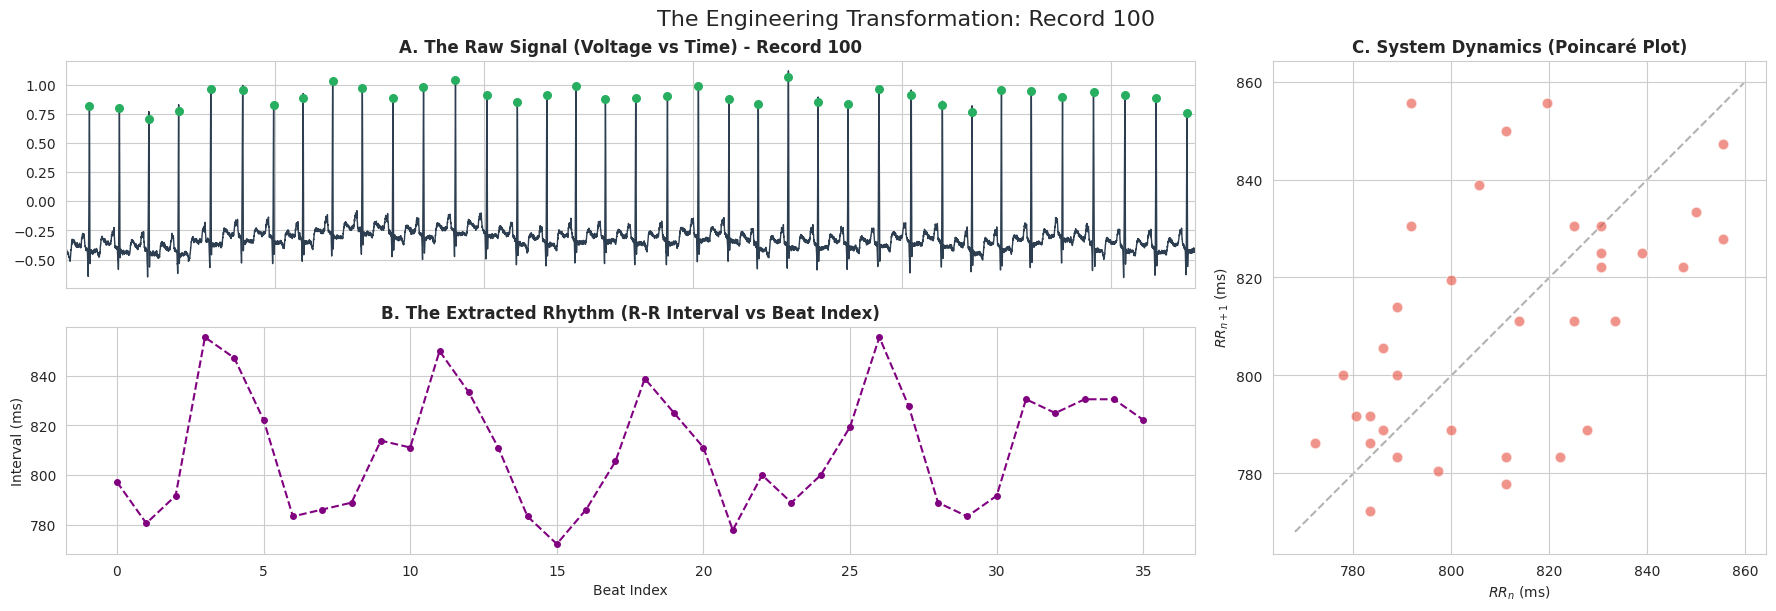

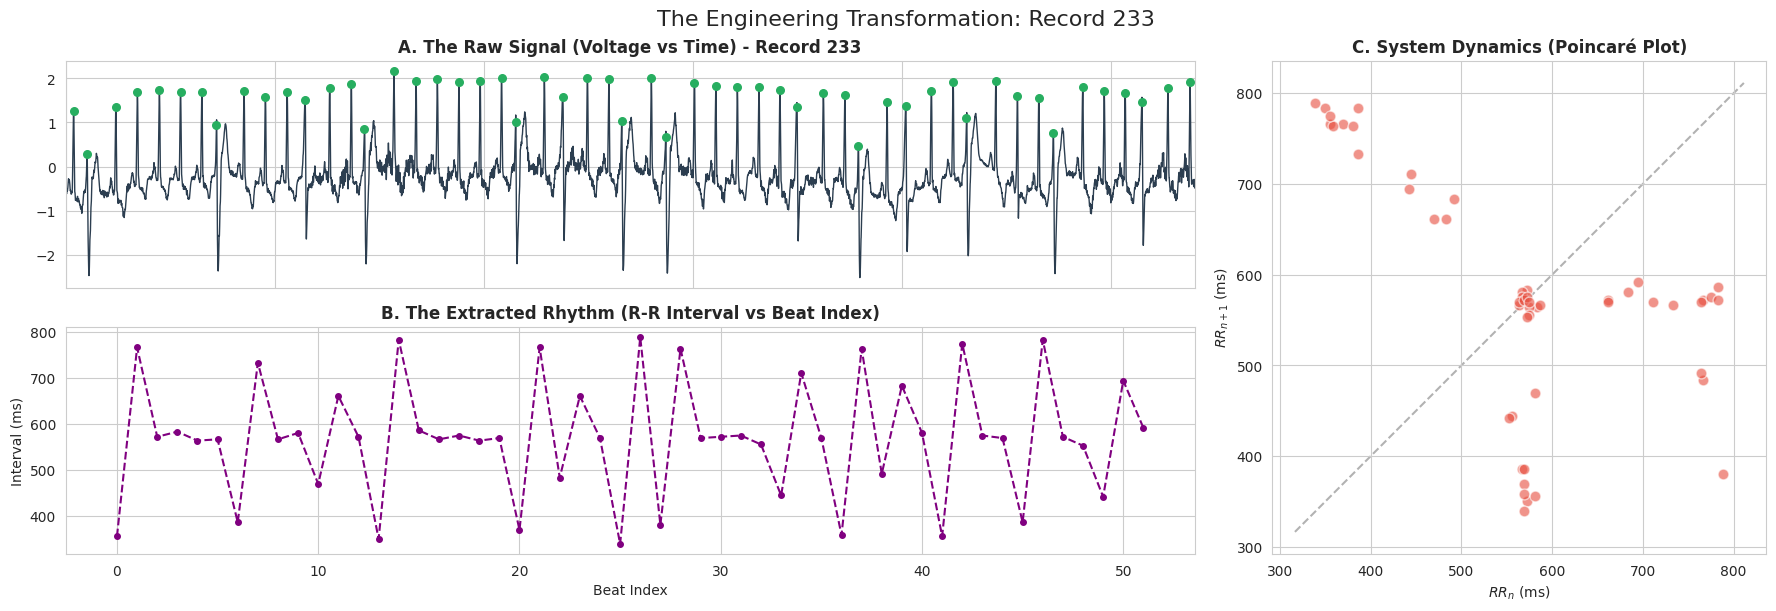

In [5]:
# @title Visualization: The Signal-to-Chaos Pipeline (Consistent)
def visualize_detailed_transformation(record_id, start_sec=100):
    # 1. Load Data
    path = os.path.join(Config.DL_DIR, record_id)
    record = wfdb.rdrecord(path)
    full_signal = record.p_signal[:, 0]
    segment = full_signal[start_sec*Config.FS : (start_sec+30)*Config.FS]

    # 2. Process (Using the Consistent Class)
    engineer = HeartEngineer()
    # CRITICAL FIX: Use the class's robust detector, not manual find_peaks
    peaks = engineer.pan_tompkins_detector(segment)

    # 3. Compute Dynamics
    if len(peaks) < 2:
        print(f"Not enough peaks found in Record {record_id} segment.")
        return

    rr_intervals_ms = np.diff(peaks) / Config.FS * 1000
    x, y = rr_intervals_ms[:-1], rr_intervals_ms[1:]

    # --- PLOTTING ---
    fig = plt.figure(figsize=(18, 6), constrained_layout=True)
    gs = fig.add_gridspec(2, 3)

    # Panel A: The Raw Physics (Voltage)
    ax1 = fig.add_subplot(gs[0, :-1])
    ax1.plot(segment, color=Config.COLOR_RAW, linewidth=1, label='Raw ECG')
    ax1.scatter(peaks, segment[peaks], c=Config.COLOR_PEAK, s=30, zorder=5)
    ax1.set_title(f"A. The Raw Signal (Voltage vs Time) - Record {record_id}", fontweight='bold')
    ax1.set_xlim(0, len(segment))
    ax1.set_xticklabels([])

    # Panel B: The Rhythm (Tachogram)
    ax2 = fig.add_subplot(gs[1, :-1])
    ax2.plot(rr_intervals_ms, color='purple', marker='o', linestyle='--', markersize=4)
    ax2.set_title("B. The Extracted Rhythm (R-R Interval vs Beat Index)", fontweight='bold')
    ax2.set_ylabel("Interval (ms)")
    ax2.set_xlabel("Beat Index")

    # Panel C: The Phase Space (Poincaré)
    ax3 = fig.add_subplot(gs[:, 2])
    ax3.scatter(x, y, c=Config.COLOR_ANOMALY, alpha=0.6, edgecolors='w', s=60)

    # Add Identity Line
    lims = [np.min([ax3.get_xlim(), ax3.get_ylim()]),  np.max([ax3.get_xlim(), ax3.get_ylim()])]
    ax3.plot(lims, lims, 'k--', alpha=0.3, zorder=0)

    ax3.set_title("C. System Dynamics (Poincaré Plot)", fontweight='bold')
    ax3.set_xlabel('$RR_n$ (ms)')
    ax3.set_ylabel('$RR_{n+1}$ (ms)')
    ax3.set_aspect('equal')

    plt.suptitle(f"The Engineering Transformation: Record {record_id}", fontsize=16)
    plt.show()

print("Visualizing Normal (100) vs Arrhythmia (203)...")
visualize_detailed_transformation('100', start_sec=50)
visualize_detailed_transformation('233', start_sec=50)

Processing 48 records...


  0%|          | 0/48 [00:00<?, ?it/s]/tmp/ipython-input-54047649.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(psd[idx_lf], freqs[idx_lf])
/tmp/ipython-input-54047649.py:93: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hf_power = np.trapz(psd[idx_hf], freqs[idx_hf])
  2%|▏         | 1/48 [00:01<00:51,  1.10s/it]/tmp/ipython-input-54047649.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(psd[idx_lf], freqs[idx_lf])
/tmp/ipython-input-54047649.py:93: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hf_power = np.trapz(psd[idx_hf], freqs[idx_hf])
  4%|▍         | 2/48 [00:02<00:

Extracted 8327 windows.
Anomaly Rate: 34.2%


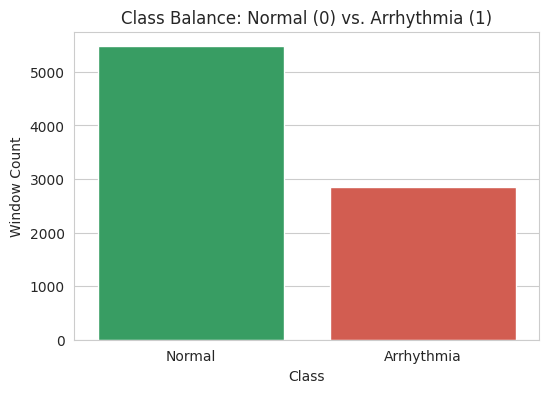

In [6]:
# @title Process Full Dataset
from tqdm import tqdm

def process_dataset(records):
    X_raw_signals = []      # For CNN
    X_engineered = []       # For SVM/LR
    y_labels = []           # 0=Normal, 1=Arrhythmia

    # Arrhythmia codes: A (Atrial), V (Ventricular), F (Fusion), etc.
    ARRHYTHMIA_SYMBOLS = {'A', 'a', 'J', 'S', 'V', 'F', '!'}
    engineer = HeartEngineer()

    print(f"Processing {len(records)} records...")

    for record_id in tqdm(records):
        try:
            path = os.path.join(Config.DL_DIR, record_id)
            record = wfdb.rdrecord(path)
            annotation = wfdb.rdann(path, 'atr')
            signal = record.p_signal[:, 0]

            # Slice into windows
            for start in range(0, len(signal) - Config.WINDOW_SIZE, Config.WINDOW_SIZE):
                end = start + Config.WINDOW_SIZE
                window = signal[start:end]

                # Check Labels
                mask = (annotation.sample >= start) & (annotation.sample < end)
                syms = np.array(annotation.symbol)[mask]
                label = 1 if any(s in ARRHYTHMIA_SYMBOLS for s in syms) else 0

                # Extract Features
                feats = engineer.extract_features(window)
                if feats is None: continue # Skip noisy windows

                X_raw_signals.append(window)
                X_engineered.append(feats)
                y_labels.append(label)

        except: continue

    # Formatting
    X_raw = np.array(X_raw_signals).reshape(-1, Config.WINDOW_SIZE, 1)
    X_eng = np.array(X_engineered)
    y = np.array(y_labels)

    print(f"Extracted {len(y)} windows.")
    print(f"Anomaly Rate: {y.mean():.1%}")
    return X_raw, X_eng, y

X_cnn, X_features, y_all = process_dataset(all_records)

# Visualize Class Balance
plt.figure(figsize=(6, 4))
sns.countplot(x=y_all, palette=[Config.COLOR_PEAK, Config.COLOR_ANOMALY])
plt.title("Class Balance: Normal (0) vs. Arrhythmia (1)")
plt.xlabel("Class")
plt.ylabel("Window Count")
plt.xticks([0, 1], ['Normal', 'Arrhythmia'])
plt.show()

In [7]:
# @title Train/Test Split
from sklearn.model_selection import train_test_split

# Split indices so we can slice both datasets identically
indices = np.arange(len(y_all))
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    indices, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Create the specific sets
X_train_cnn, X_test_cnn = X_cnn[X_train_idx], X_cnn[X_test_idx]
X_train_eng, X_test_eng = X_features[X_train_idx], X_features[X_test_idx]

print(f"Training Samples: {len(y_train)}")
print(f"Testing Samples: {len(y_test)}")

Training Samples: 6661
Testing Samples: 1666


In [8]:
# @title Model A: The Engineer (Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import time

# Pipeline: Scale features -> LogReg
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced'))
])

start_time = time.time()
pipe.fit(X_train_eng, y_train)
eng_time = time.time() - start_time

print(f"Training Time: {eng_time:.4f} seconds")
print("\n--- Engineering Model Results ---")
y_pred_eng = pipe.predict(X_test_eng)
print(classification_report(y_test, y_pred_eng, target_names=['Normal', 'Arrhythmia']))

Training Time: 0.0280 seconds

--- Engineering Model Results ---
              precision    recall  f1-score   support

      Normal       0.87      0.86      0.87      1096
  Arrhythmia       0.75      0.76      0.75       570

    accuracy                           0.83      1666
   macro avg       0.81      0.81      0.81      1666
weighted avg       0.83      0.83      0.83      1666



Computed Class Weights: {0: np.float64(0.7603881278538813), 1: np.float64(1.4601052170100832)}
Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.6213 - loss: 0.6615 - val_accuracy: 0.6852 - val_loss: 0.6148
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6753 - loss: 0.6079 - val_accuracy: 0.6852 - val_loss: 0.6026
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6994 - loss: 0.5765 - val_accuracy: 0.6897 - val_loss: 0.5828
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7333 - loss: 0.5460 - val_accuracy: 0.6912 - val_loss: 0.5573
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7346 - loss: 0.5367 - val_accuracy: 0.7346 - val_loss: 0.5384
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7569 - loss: 0.4991 - val_accuracy: 0.7676 - val_loss: 0.4954
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7614 - loss: 0.4967 - val_accuracy: 0.7661 - val_loss: 0.4788
Epoch 8/20
94/9

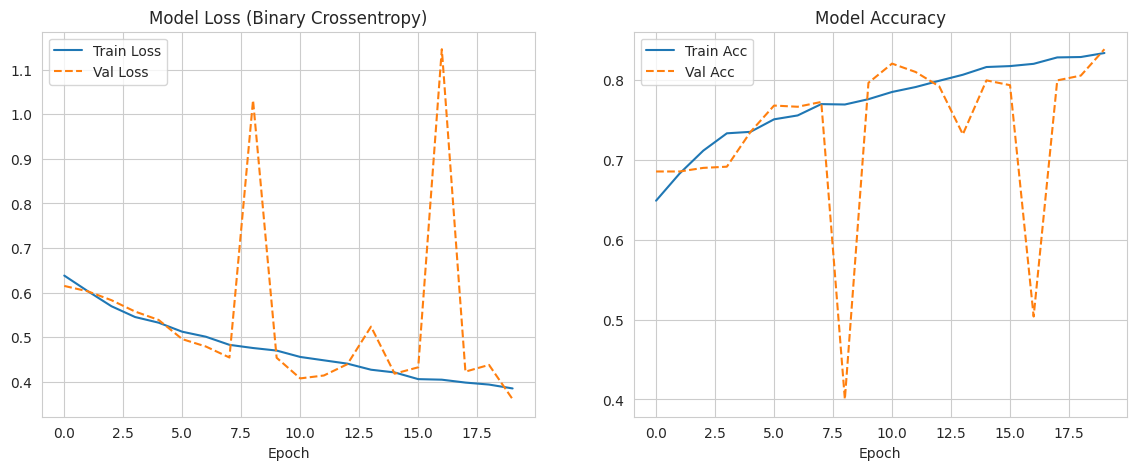

In [9]:
# @title Model B: The Deep Learner (CNN) with Class Balancing
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.utils import class_weight

# 1. Calculate Class Weights (To handle the 2:1 Imbalance)
# This ensures the model pays 2x more attention to Arrhythmia if it's 2x rarer.
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(weights))
print(f"Computed Class Weights: {class_weights_dict}")

# 2. Build Model
def build_cnn():
    model = models.Sequential([
        layers.Input(shape=(Config.WINDOW_SIZE, 1)),
        # Conv Block 1
        layers.Conv1D(32, 5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        # Conv Block 2
        layers.Conv1D(64, 5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        # Dense
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_cnn = build_cnn()

# 3. Train with Weights
start_time = time.time()
history = model_cnn.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    class_weight=class_weights_dict # <--- The Key Fix
)
cnn_time = time.time() - start_time

# --- VISUALIZATION: Learning Curves ---
def plot_learning_curves(hist):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    ax[0].plot(hist.history['loss'], label='Train Loss')
    ax[0].plot(hist.history['val_loss'], label='Val Loss', linestyle='--')
    ax[0].set_title("Model Loss (Binary Crossentropy)")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()

    # Accuracy
    ax[1].plot(hist.history['accuracy'], label='Train Acc')
    ax[1].plot(hist.history['val_accuracy'], label='Val Acc', linestyle='--')
    ax[1].set_title("Model Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()

    plt.show()

plot_learning_curves(history)

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


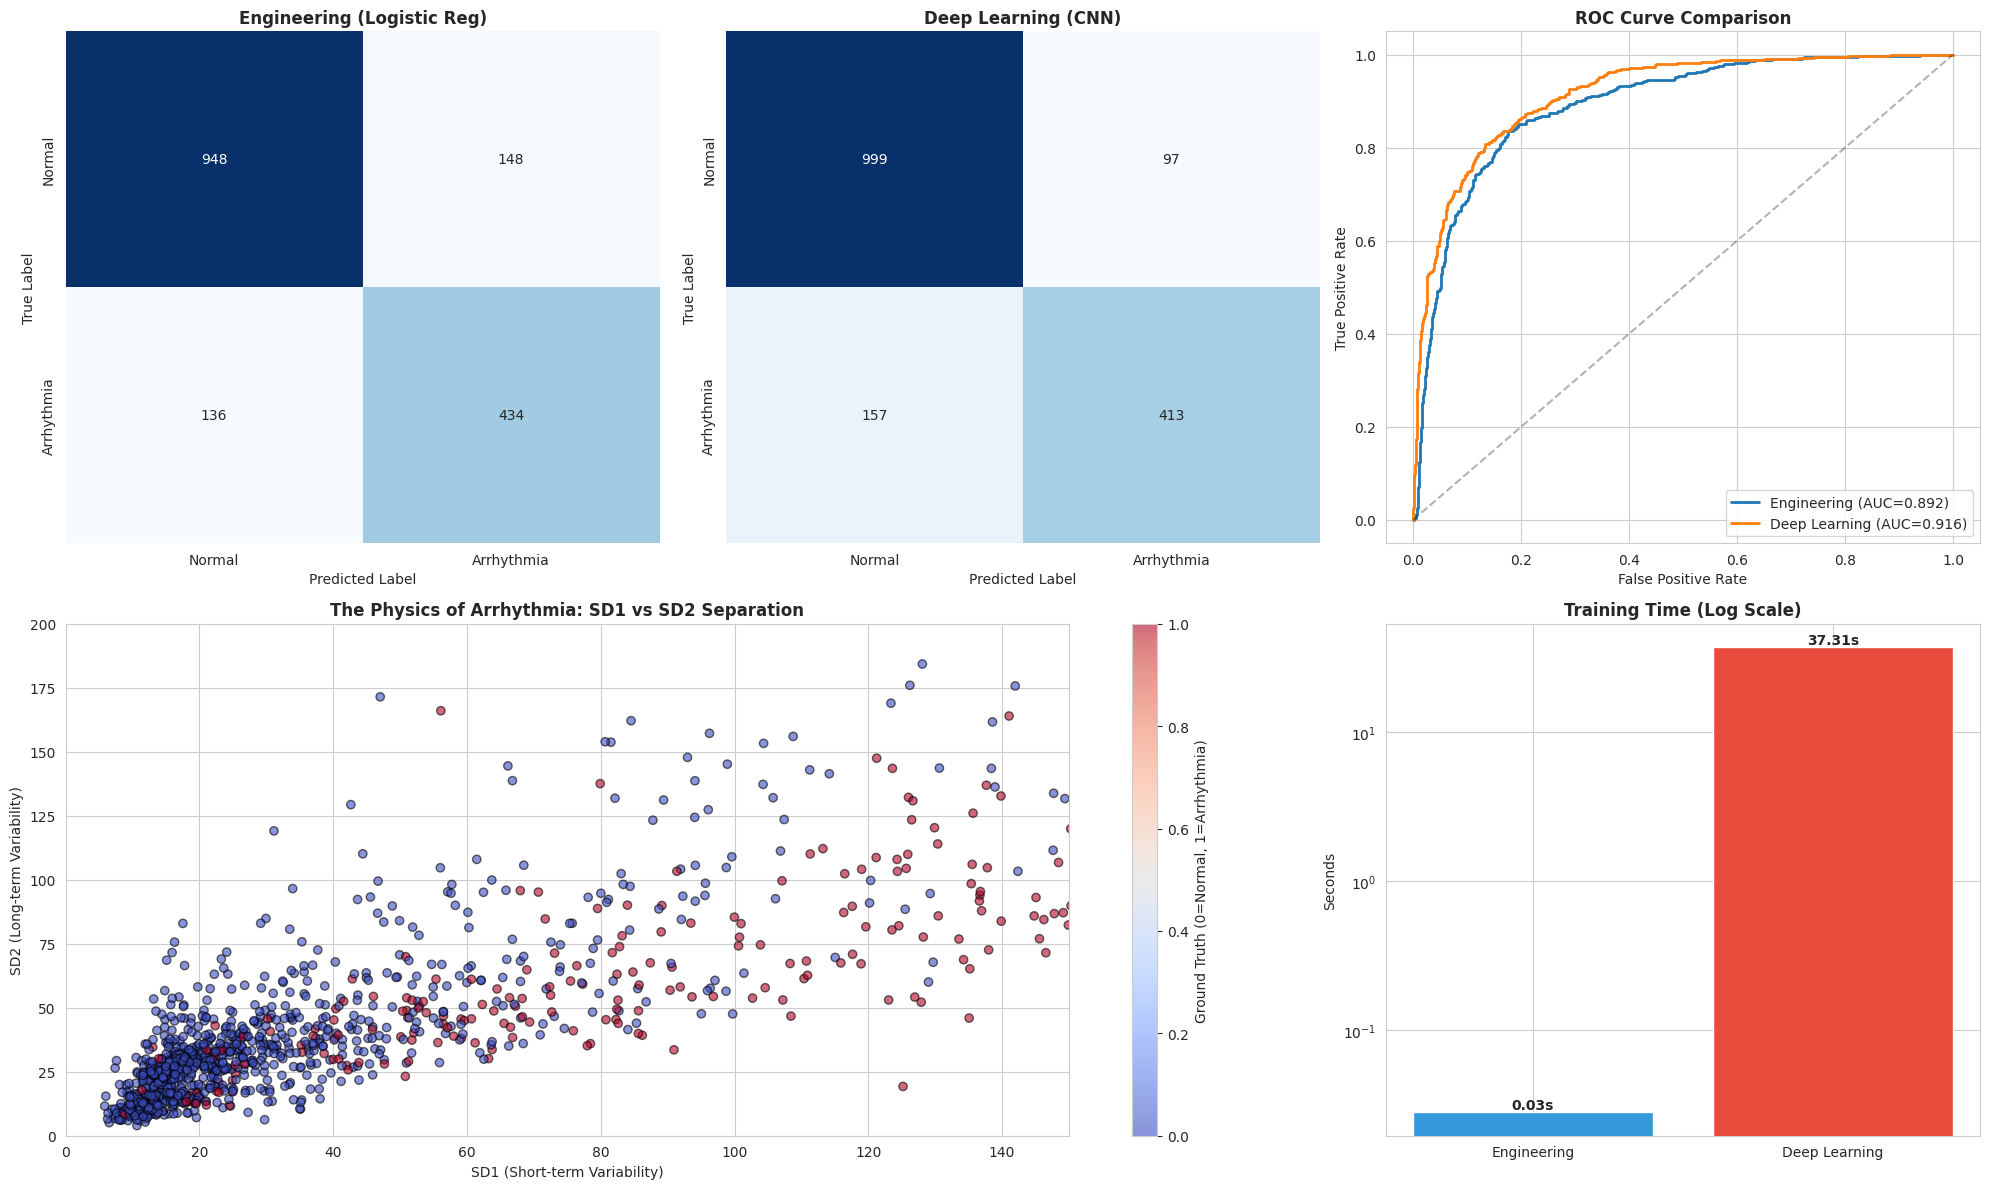

In [10]:
# @title Final Evaluation Dashboard
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Generate Predictions
y_pred_eng = pipe.predict(X_test_eng)
y_prob_eng = pipe.predict_proba(X_test_eng)[:, 1]

y_pred_cnn_prob = model_cnn.predict(X_test_cnn).flatten()
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int)

# 2. Setup Dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)

# --- PANEL 1: Confusion Matrices ---
def plot_cm(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=['Normal', 'Arrhythmia'], yticklabels=['Normal', 'Arrhythmia'])
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

ax_cm1 = fig.add_subplot(gs[0, 0])
plot_cm(ax_cm1, y_test, y_pred_eng, "Engineering (Logistic Reg)")

ax_cm2 = fig.add_subplot(gs[0, 1])
plot_cm(ax_cm2, y_test, y_pred_cnn, "Deep Learning (CNN)")

# --- PANEL 2: ROC Curves ---
ax_roc = fig.add_subplot(gs[0, 2])
fpr_eng, tpr_eng, _ = roc_curve(y_test, y_prob_eng)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn_prob)

ax_roc.plot(fpr_eng, tpr_eng, label=f'Engineering (AUC={auc(fpr_eng, tpr_eng):.3f})', linewidth=2)
ax_roc.plot(fpr_cnn, tpr_cnn, label=f'Deep Learning (AUC={auc(fpr_cnn, tpr_cnn):.3f})', linewidth=2)
ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax_roc.set_title("ROC Curve Comparison", fontweight='bold')
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend(loc='lower right')

# --- PANEL 3: The "Why It Works" (Phase Space Decision) ---
# Visualizing SD1 vs SD2 separation
ax_scatter = fig.add_subplot(gs[1, :2])
sc = ax_scatter.scatter(X_test_eng[:, 0], X_test_eng[:, 1], c=y_test, cmap='coolwarm', alpha=0.6, edgecolors='k')
ax_scatter.set_title("The Physics of Arrhythmia: SD1 vs SD2 Separation", fontweight='bold')
ax_scatter.set_xlabel("SD1 (Short-term Variability)")
ax_scatter.set_ylabel("SD2 (Long-term Variability)")
# Zoom in on the dense cluster
ax_scatter.set_xlim(0, 150)
ax_scatter.set_ylim(0, 200)

# Add colorbar
plt.colorbar(sc, ax=ax_scatter, label="Ground Truth (0=Normal, 1=Arrhythmia)")

# --- PANEL 4: Cost Comparison ---
ax_cost = fig.add_subplot(gs[1, 2])
costs = [eng_time, cnn_time]
ax_cost.bar(['Engineering', 'Deep Learning'], costs, color=['#3498db', '#e74c3c'])
ax_cost.set_yscale('log')
ax_cost.set_title("Training Time (Log Scale)", fontweight='bold')
ax_cost.set_ylabel("Seconds")
for i, v in enumerate(costs):
    ax_cost.text(i, v, f"{v:.2f}s", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Visualizing a correctly detected Arrhythmia...


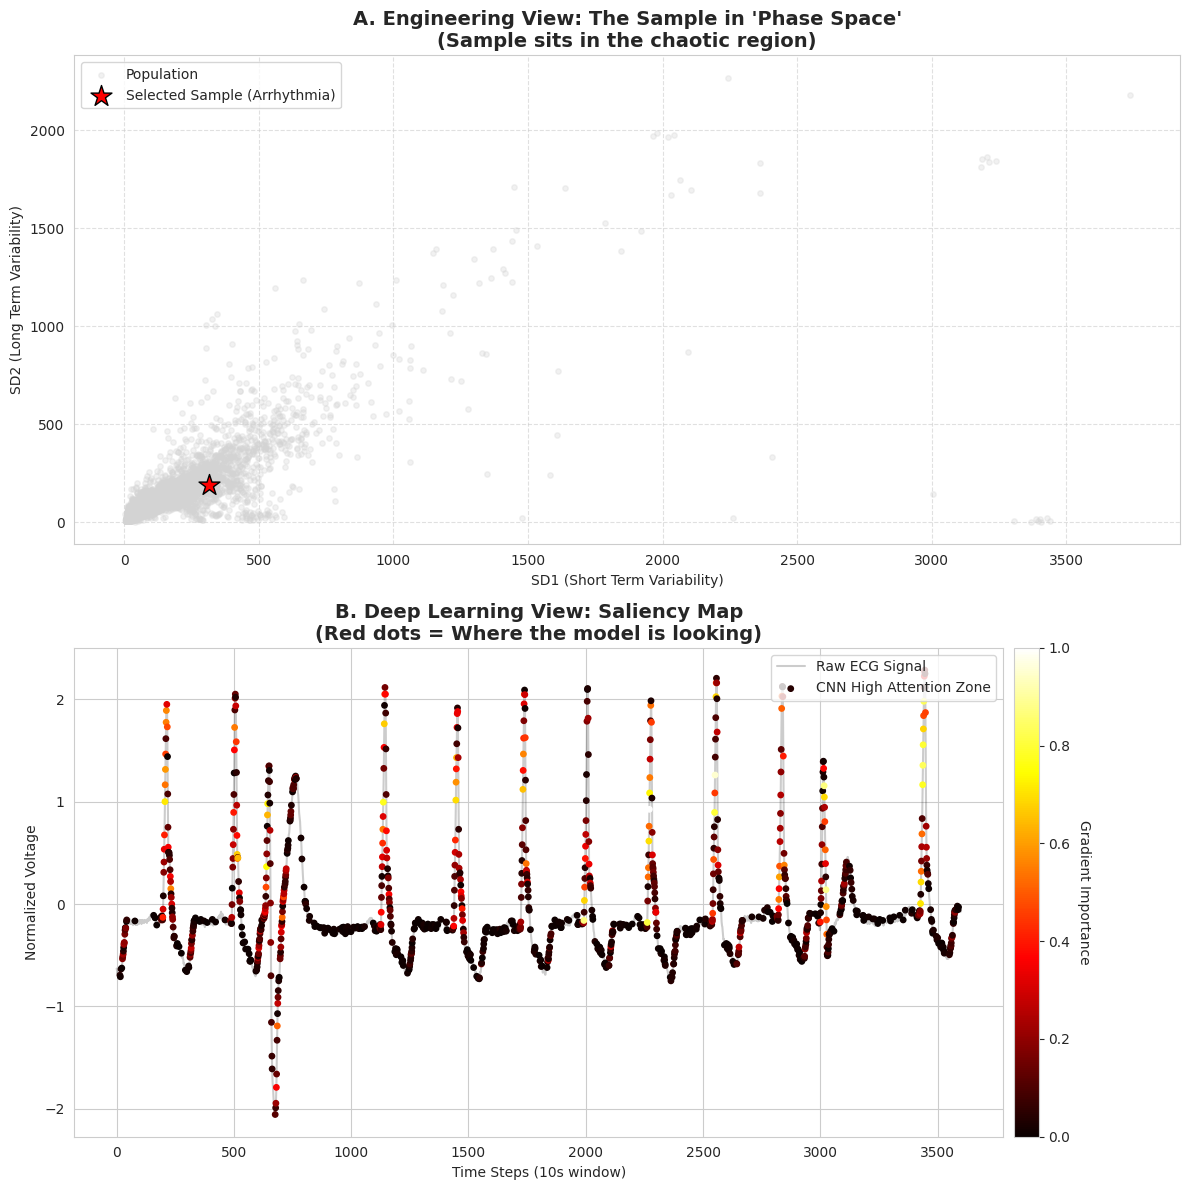

In [11]:
# @title The "Black Box" Problem: Saliency Map Visualization (Stacked)
def compute_saliency(model, input_signal):
    # Convert to tensor
    tensor_input = tf.convert_to_tensor(input_signal.reshape(1, -1, 1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(tensor_input)
        predictions = model(tensor_input)

    # Get gradients
    grads = tape.gradient(predictions, tensor_input)

    # Normalize
    saliency = tf.abs(grads)
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))
    return saliency.numpy().flatten()

def visualize_interpretability(index):
    # Get a sample
    sample_raw = X_test_cnn[index].flatten()
    sample_eng = X_test_eng[index]
    true_label = y_test[index]

    # Compute CNN Saliency
    saliency_map = compute_saliency(model_cnn, sample_raw)

    # --- PLOTTING (Stacked) ---
    fig, ax = plt.subplots(2, 1, figsize=(12, 12)) # Vertical Stack

    # TOP PANEL: The Engineering View (Poincaré)
    # Background population
    ax[0].scatter(X_train_eng[:, 0], X_train_eng[:, 1], c='lightgray', alpha=0.3, s=15, label='Population')

    # The specific sample
    color = 'red' if true_label == 1 else 'green'
    label_text = "Arrhythmia" if true_label == 1 else "Normal"

    ax[0].scatter(sample_eng[0], sample_eng[1], c=color, s=250, edgecolors='k', marker='*', zorder=5, label=f'Selected Sample ({label_text})')

    ax[0].set_xlabel('SD1 (Short Term Variability)')
    ax[0].set_ylabel('SD2 (Long Term Variability)')
    ax[0].set_title(f"A. Engineering View: The Sample in 'Phase Space'\n(Sample sits in the chaotic region)", fontweight='bold', fontsize=14)
    ax[0].legend(loc='upper left')
    ax[0].grid(True, linestyle='--', alpha=0.6)

    # BOTTOM PANEL: The DL View (Saliency)
    # 1. Plot the faint raw signal
    ax[1].plot(sample_raw, color='black', alpha=0.2, linewidth=1.5, label='Raw ECG Signal')

    # 2. Overlay Saliency (High Attention Areas)
    # Threshold to only show strong attention (top 30% of gradients)
    threshold = np.percentile(saliency_map, 70)
    mask = saliency_map > threshold

    # We plot the "Attention" as red dots on top of the signal
    ax[1].scatter(np.arange(len(sample_raw))[mask], sample_raw[mask],
                  c=saliency_map[mask], cmap='hot', s=15, zorder=5, label='CNN High Attention Zone')

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=1))
    cbar = plt.colorbar(sm, ax=ax[1], pad=0.01)
    cbar.set_label('Gradient Importance', rotation=270, labelpad=15)

    ax[1].set_title(f"B. Deep Learning View: Saliency Map\n(Red dots = Where the model is looking)", fontweight='bold', fontsize=14)
    ax[1].set_xlabel("Time Steps (10s window)")
    ax[1].set_ylabel("Normalized Voltage")
    ax[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Find an Arrhythmia sample to inspect
# We search for a True Positive (Model Correctly predicted Arrhythmia) for the best demo
arrhythmia_indices = np.where((y_test == 1) & (y_pred_cnn.flatten() == 1))[0]

if len(arrhythmia_indices) > 0:
    print("Visualizing a correctly detected Arrhythmia...")
    visualize_interpretability(arrhythmia_indices[2]) # Picking the 3rd one for variety
else:
    print("No correctly detected arrhythmia found to visualize.")

Reprocessing for 5-Class Classification...


  0%|          | 0/48 [00:00<?, ?it/s]/tmp/ipython-input-54047649.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(psd[idx_lf], freqs[idx_lf])
/tmp/ipython-input-54047649.py:93: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hf_power = np.trapz(psd[idx_hf], freqs[idx_hf])
  2%|▏         | 1/48 [00:00<00:44,  1.07it/s]/tmp/ipython-input-54047649.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(psd[idx_lf], freqs[idx_lf])
/tmp/ipython-input-54047649.py:93: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hf_power = np.trapz(psd[idx_hf], freqs[idx_hf])
  4%|▍         | 2/48 [00:01<00:

Extracted 7889 windows.


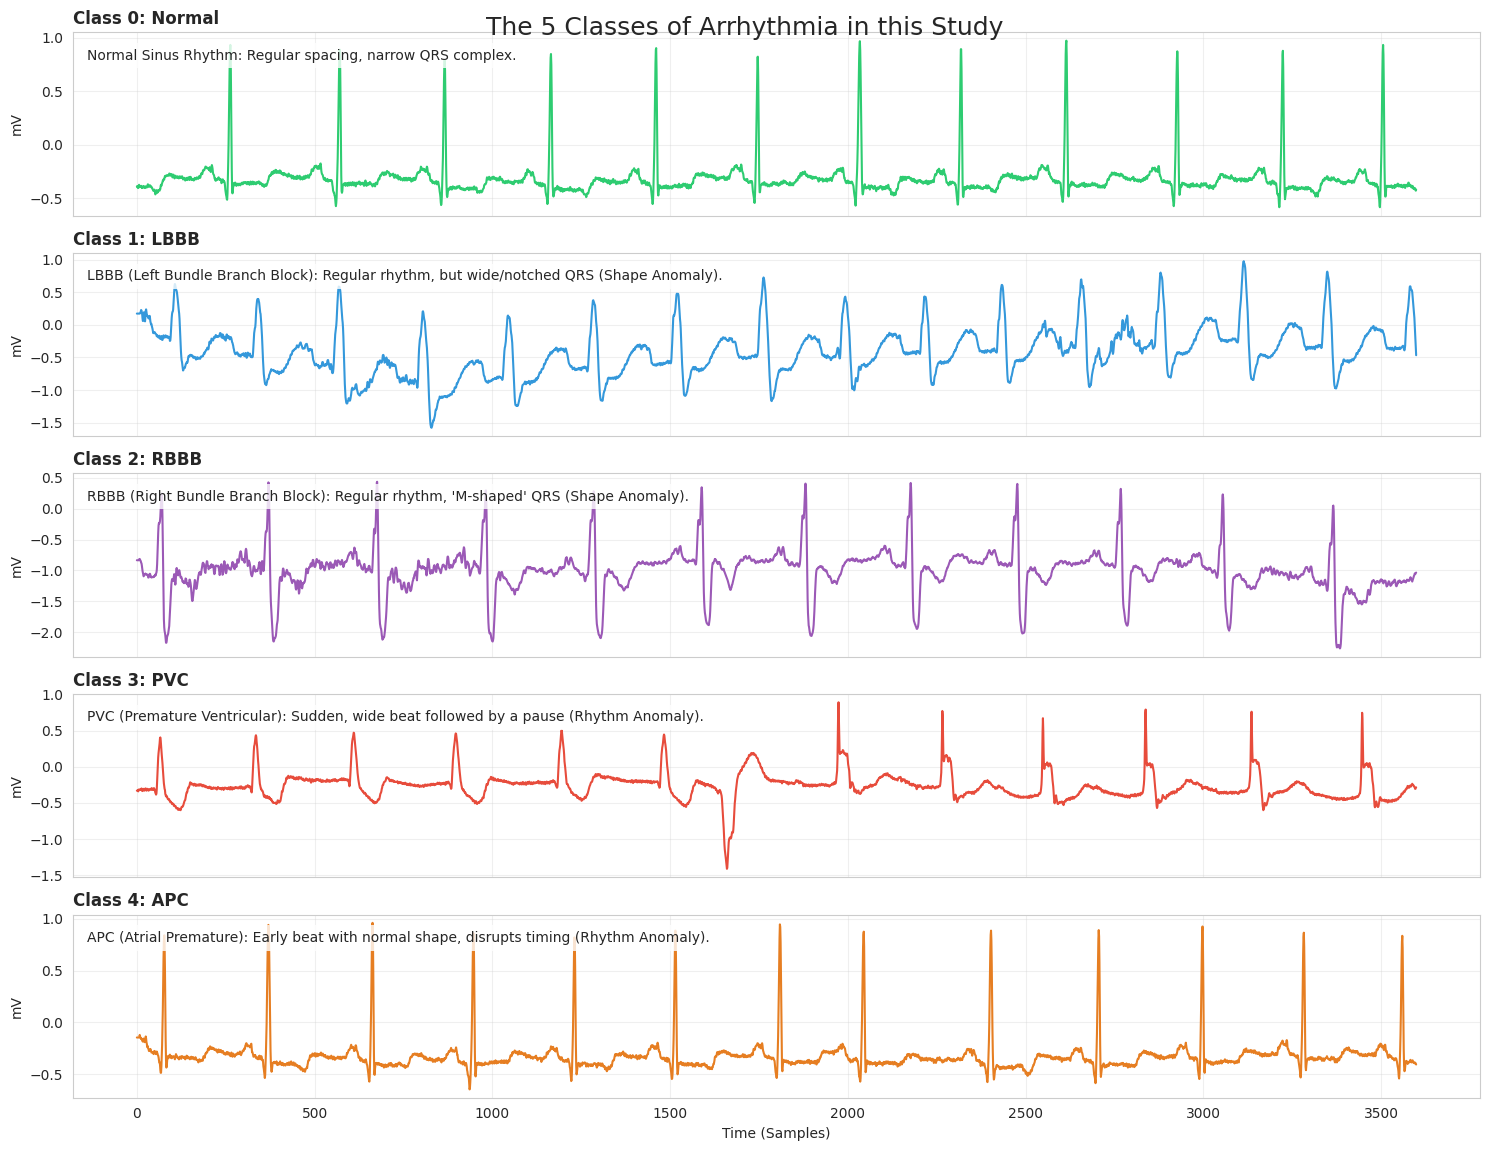

In [12]:
# @title Multiclass: Re-Labeling & Visualization
def process_multiclass_dataset(records):
    X_raw_signals = []
    X_engineered = []
    y_labels = []

    # Class Mapping (PhysioNet Standards)
    # N=Normal, L=Left Bundle Branch Block, R=Right Bundle Branch Block, V=PVC, A=APC
    CLASS_MAP = {'N': 0, 'L': 1, 'R': 2, 'V': 3, 'A': 4}
    CLASS_NAMES = ['Normal', 'LBBB', 'RBBB', 'PVC', 'APC']

    engineer = HeartEngineer()

    print(f"Reprocessing for 5-Class Classification...")

    for record_id in tqdm(records):
        try:
            path = os.path.join(Config.DL_DIR, record_id)
            record = wfdb.rdrecord(path)
            annotation = wfdb.rdann(path, 'atr')
            signal = record.p_signal[:, 0]

            for start in range(0, len(signal) - Config.WINDOW_SIZE, Config.WINDOW_SIZE):
                end = start + Config.WINDOW_SIZE

                # Get annotations in this window
                mask = (annotation.sample >= start) & (annotation.sample < end)
                syms = np.array(annotation.symbol)[mask]

                # LOGIC: Hierarchy of Severity (V > A > L > R > N)
                if 'V' in syms: label = 3
                elif 'A' in syms or 'a' in syms: label = 4
                elif 'L' in syms: label = 1
                elif 'R' in syms: label = 2
                elif 'N' in syms or '.' in syms: label = 0
                else: continue

                window = signal[start:end]
                feats = engineer.extract_features(window)
                if feats is None: continue

                X_raw_signals.append(window)
                X_engineered.append(feats)
                y_labels.append(label)

        except: continue

    X_raw = np.array(X_raw_signals).reshape(-1, Config.WINDOW_SIZE, 1)
    X_eng = np.array(X_engineered)
    y = np.array(y_labels)

    print(f"Extracted {len(y)} windows.")
    return X_raw, X_eng, y, CLASS_NAMES

# 1. Run Processing
X_cnn_mc, X_eng_mc, y_mc, CLASS_NAMES = process_multiclass_dataset(all_records)

# 2. VISUALIZATION: The "Medical Chart"
def plot_class_examples():
    fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

    descriptions = {
        0: "Normal Sinus Rhythm: Regular spacing, narrow QRS complex.",
        1: "LBBB (Left Bundle Branch Block): Regular rhythm, but wide/notched QRS (Shape Anomaly).",
        2: "RBBB (Right Bundle Branch Block): Regular rhythm, 'M-shaped' QRS (Shape Anomaly).",
        3: "PVC (Premature Ventricular): Sudden, wide beat followed by a pause (Rhythm Anomaly).",
        4: "APC (Atrial Premature): Early beat with normal shape, disrupts timing (Rhythm Anomaly)."
    }

    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#e67e22']

    for label_id, ax in enumerate(axes):
        # Find the first index that matches this class
        indices = np.where(y_mc == label_id)[0]
        if len(indices) == 0: continue

        idx = indices[0] # Take the first example found
        signal = X_cnn_mc[idx].flatten()

        ax.plot(signal, color=colors[label_id], linewidth=1.5)
        ax.set_title(f"Class {label_id}: {CLASS_NAMES[label_id]}", fontweight='bold', loc='left')
        ax.text(0.01, 0.85, descriptions[label_id], transform=ax.transAxes,
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        ax.grid(True, alpha=0.3)
        ax.set_ylabel("mV")

    axes[-1].set_xlabel("Time (Samples)")
    plt.suptitle("The 5 Classes of Arrhythmia in this Study", fontsize=18, y=0.95)
    plt.tight_layout()
    plt.show()

plot_class_examples()

# 3. Stratified Split
X_train_eng_mc, X_test_eng_mc, y_train_mc, y_test_mc = train_test_split(
    X_eng_mc, y_mc, test_size=0.2, random_state=42, stratify=y_mc
)
X_train_cnn_mc, X_test_cnn_mc, _, _ = train_test_split(
    X_cnn_mc, y_mc, test_size=0.2, random_state=42, stratify=y_mc
)

Training Multiclass Engineering Model (Logistic Regression)...
Engineering Model Trained.

Training Multiclass CNN...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


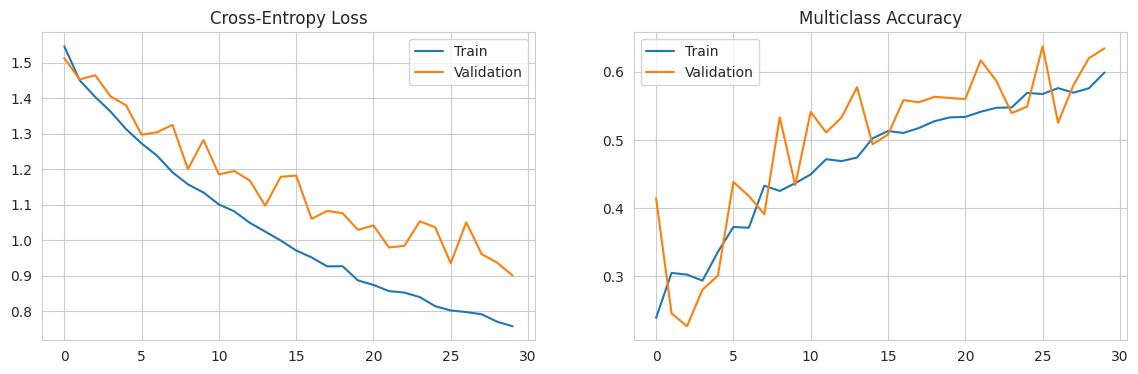

In [13]:
# @title Train Multiclass Models (with History Plot)
from sklearn.multiclass import OneVsRestClassifier

# --- 1. Engineering Model ---
print("Training Multiclass Engineering Model (Logistic Regression)...")
pipe_mc = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, class_weight='balanced'))
])
pipe_mc.fit(X_train_eng_mc, y_train_mc)
print(f"Engineering Model Trained.")

# --- 2. Deep Learning Model ---
print("\nTraining Multiclass CNN...")
def build_multiclass_cnn():
    model = models.Sequential([
        layers.Input(shape=(Config.WINDOW_SIZE, 1)),
        layers.Conv1D(32, 5, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 5, activation='relu'),
        layers.MaxPooling1D(2),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(5, activation='softmax') # Softmax for Multiclass
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_cnn_mc = build_multiclass_cnn()
weights_mc = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_mc), y=y_train_mc)
weights_dict_mc = dict(enumerate(weights_mc))

history_mc = model_cnn_mc.fit(
    X_train_cnn_mc, y_train_mc,
    epochs=30, # Increased epochs for harder task
    batch_size=64,
    validation_split=0.1,
    verbose=0,
    class_weight=weights_dict_mc
)

# --- VISUALIZATION: Training History ---
def plot_multiclass_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].plot(hist.history['loss'], label='Train')
    ax[0].plot(hist.history['val_loss'], label='Validation')
    ax[0].set_title("Cross-Entropy Loss")
    ax[0].legend()

    ax[1].plot(hist.history['accuracy'], label='Train')
    ax[1].plot(hist.history['val_accuracy'], label='Validation')
    ax[1].set_title("Multiclass Accuracy")
    ax[1].legend()
    plt.show()

plot_multiclass_history(history_mc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


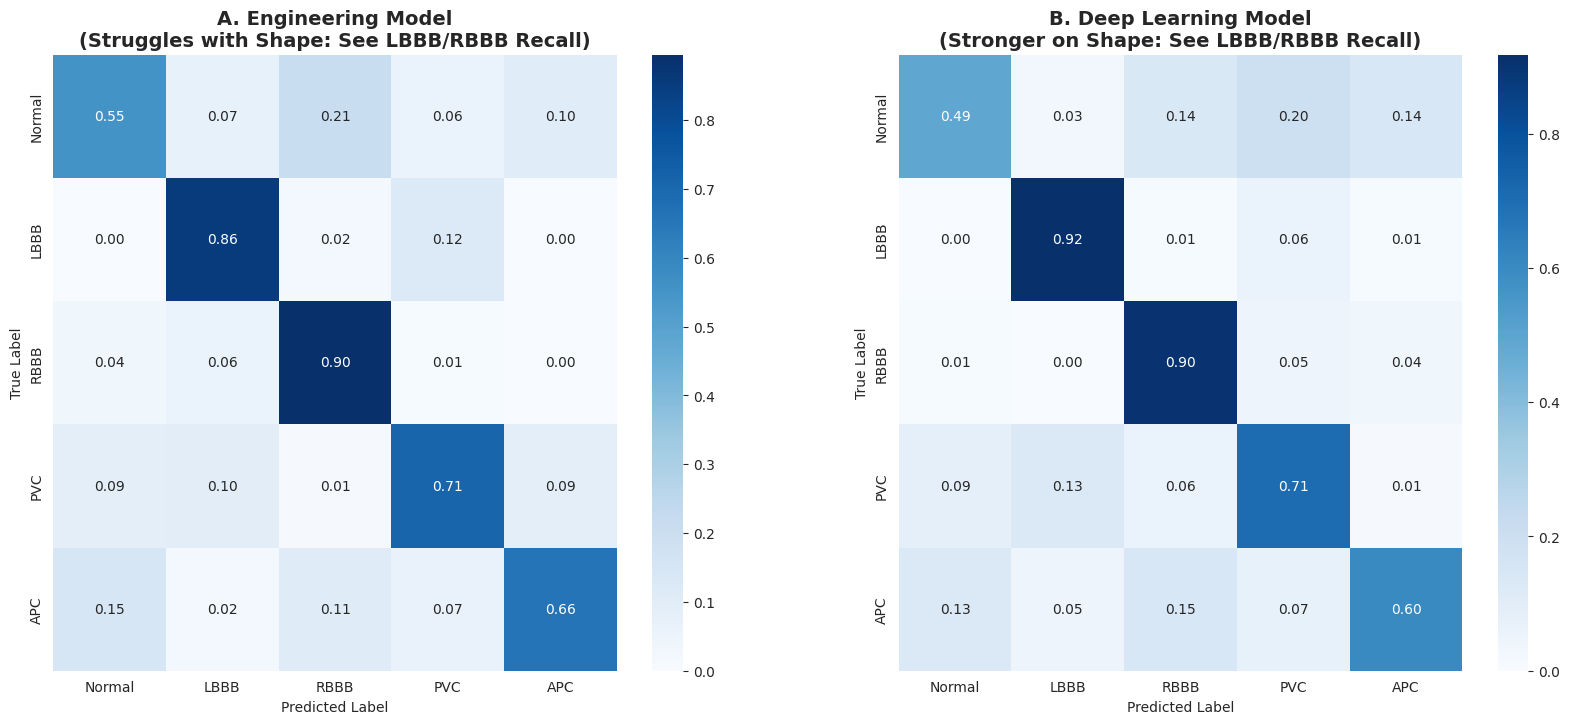

/tmp/ipython-input-1019874658.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_custom = plt.cm.get_cmap('viridis', 3)


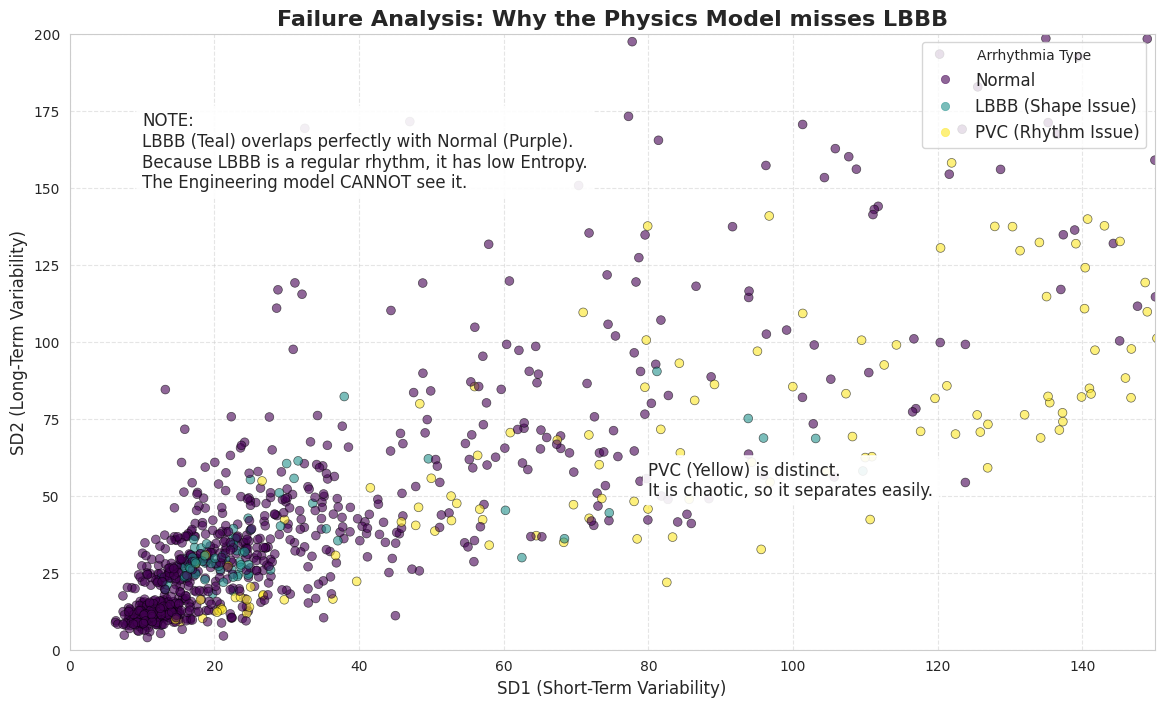

In [14]:
# @title Multiclass Evaluation: Shape vs. Rhythm
y_pred_eng_mc = pipe_mc.predict(X_test_eng_mc)
y_pred_cnn_prob_mc = model_cnn_mc.predict(X_test_cnn_mc)
y_pred_cnn_mc = np.argmax(y_pred_cnn_prob_mc, axis=1)

# --- VISUALIZATION 1: Confusion Matrices ---
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

def plot_cm_norm(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize by row
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plot_cm_norm(ax[0], y_test_mc, y_pred_eng_mc, "A. Engineering Model\n(Struggles with Shape: See LBBB/RBBB Recall)")
plot_cm_norm(ax[1], y_test_mc, y_pred_cnn_mc, "B. Deep Learning Model\n(Stronger on Shape: See LBBB/RBBB Recall)")
plt.show()

# --- VISUALIZATION 2: The "Why It Failed" Scatter Plot ---
plt.figure(figsize=(14, 8))

# We specifically plot Normal(0), LBBB(1), and PVC(3) to show the contrast
target_classes = [0, 1, 3]
indices = [i for i, x in enumerate(y_test_mc) if x in target_classes]
subset_x = X_test_eng_mc[indices]
subset_y = y_test_mc[indices]

# Define specific colors to match the confusion matrix analysis
cmap_custom = plt.cm.get_cmap('viridis', 3)

scatter = plt.scatter(subset_x[:, 0], subset_x[:, 1], c=subset_y, cmap=cmap_custom, alpha=0.6, s=40, edgecolors='k', linewidth=0.5)

# Annotations to explain the plot to the viewer
plt.title("Failure Analysis: Why the Physics Model misses LBBB", fontsize=16, fontweight='bold')
plt.xlabel("SD1 (Short-Term Variability)", fontsize=12)
plt.ylabel("SD2 (Long-Term Variability)", fontsize=12)

# Custom Legend
handles, _ = scatter.legend_elements()
labels = ['Normal', 'LBBB (Shape Issue)', 'PVC (Rhythm Issue)']
plt.legend(handles, labels, title="Arrhythmia Type", loc='upper right', fontsize=12)

# Add explanatory text on the plot
plt.text(10, 150, "NOTE:\nLBBB (Teal) overlaps perfectly with Normal (Purple).\nBecause LBBB is a regular rhythm, it has low Entropy.\nThe Engineering model CANNOT see it.",
         fontsize=12, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

plt.text(80, 50, "PVC (Yellow) is distinct.\nIt is chaotic, so it separates easily.",
         fontsize=12, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

plt.xlim(0, 150)
plt.ylim(0, 200)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Generating Chaos Gallery (Fixed & Consistent)...


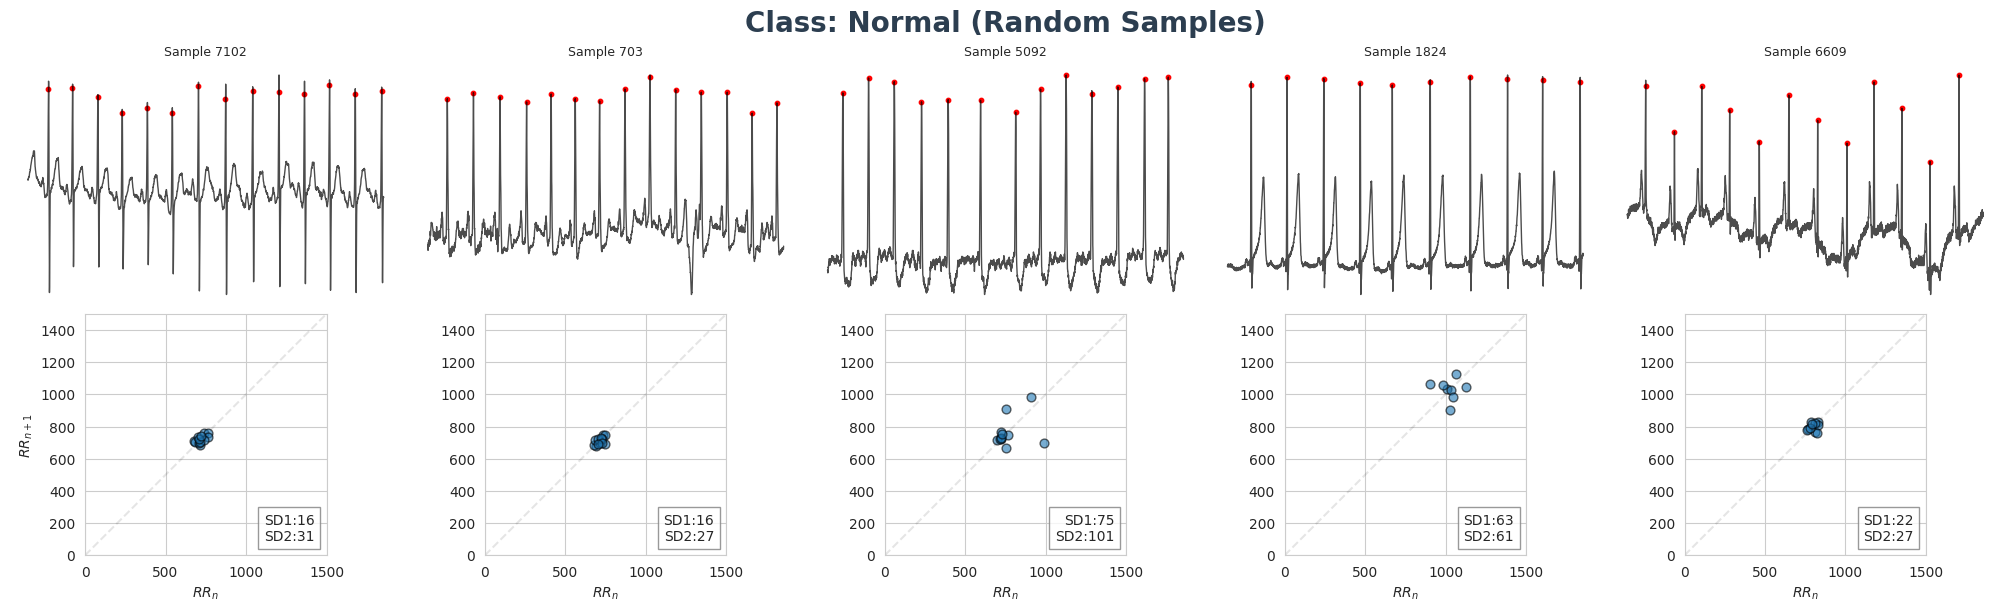

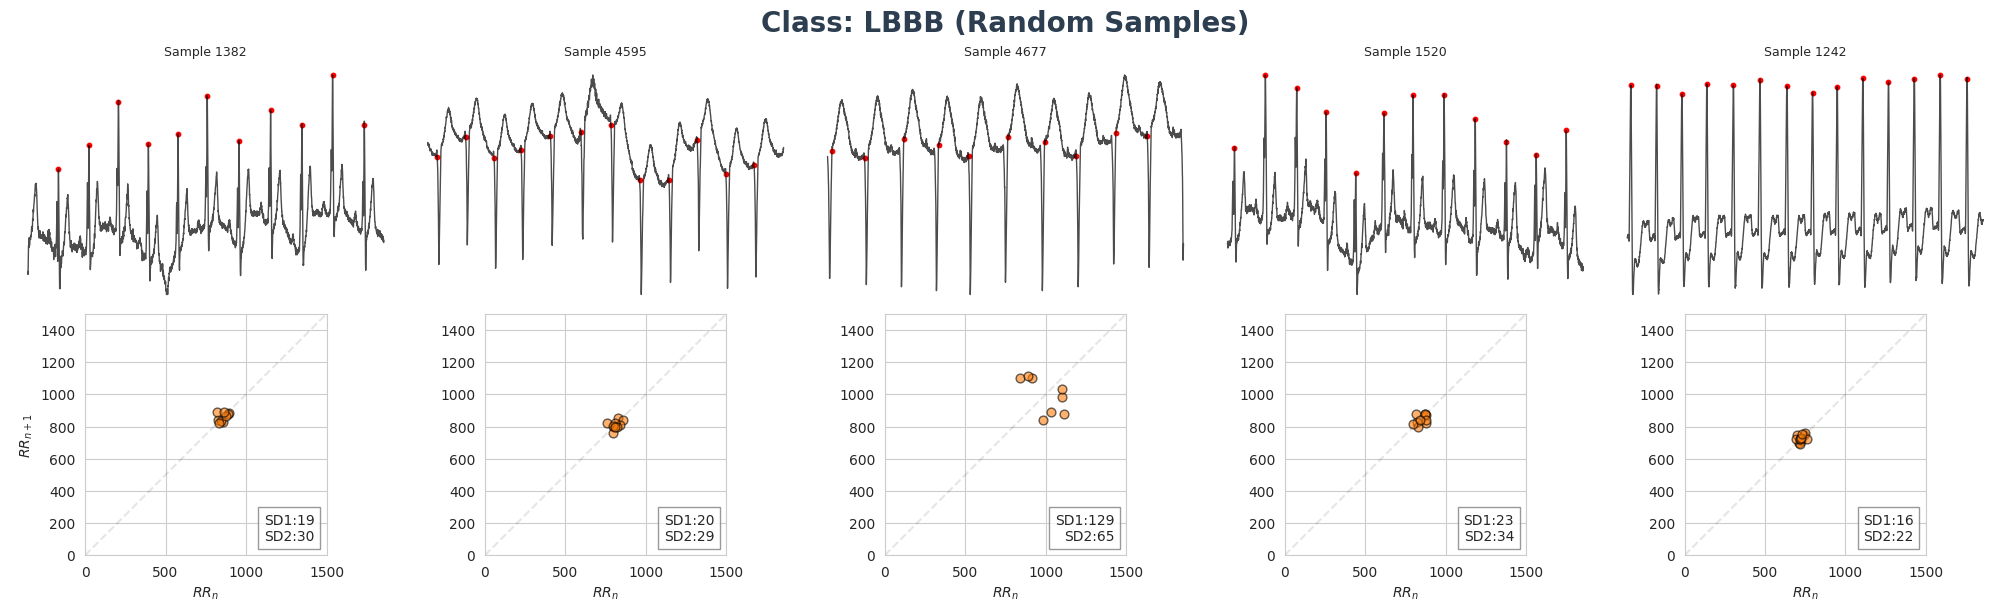

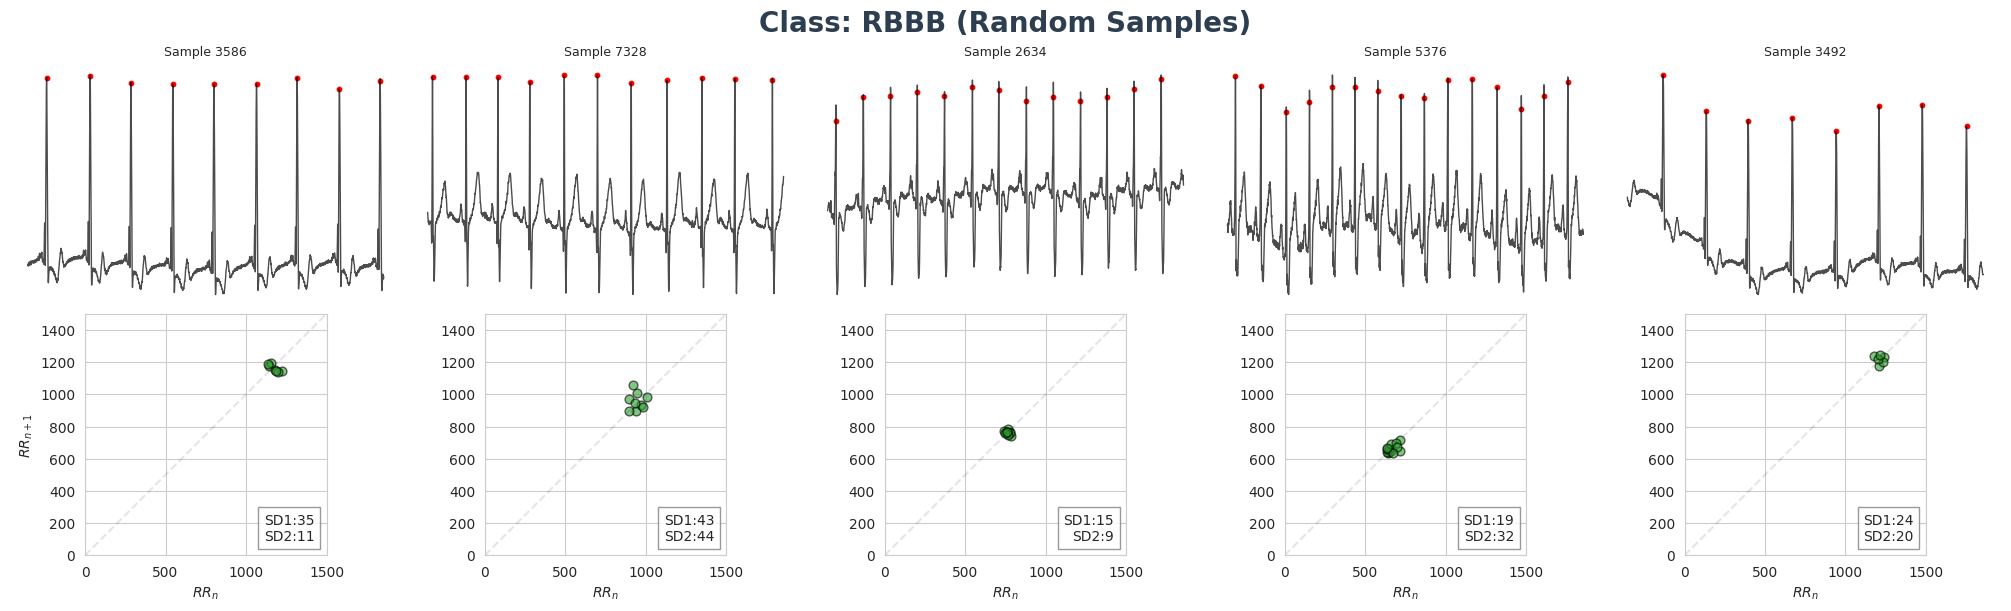

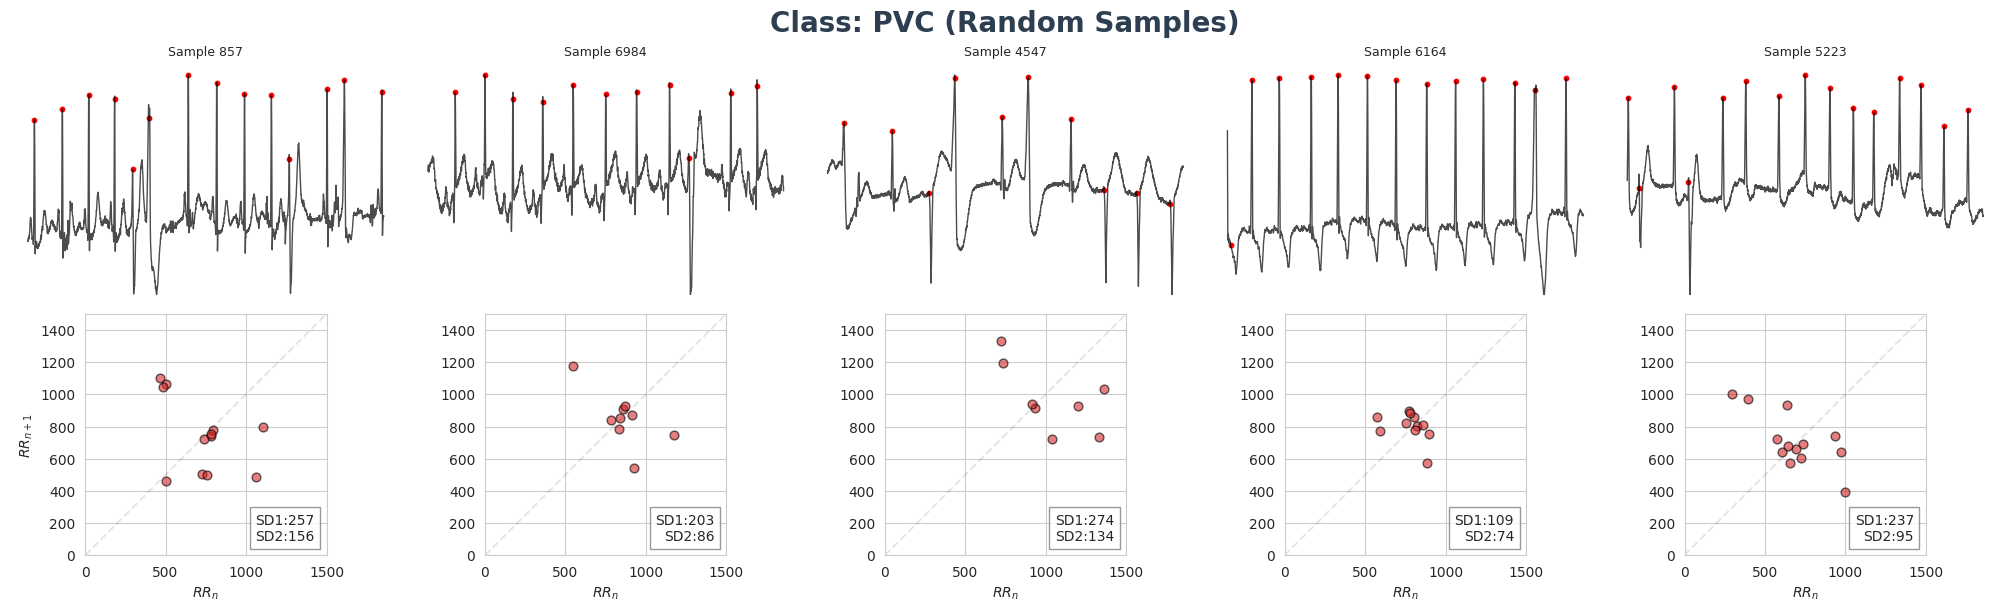

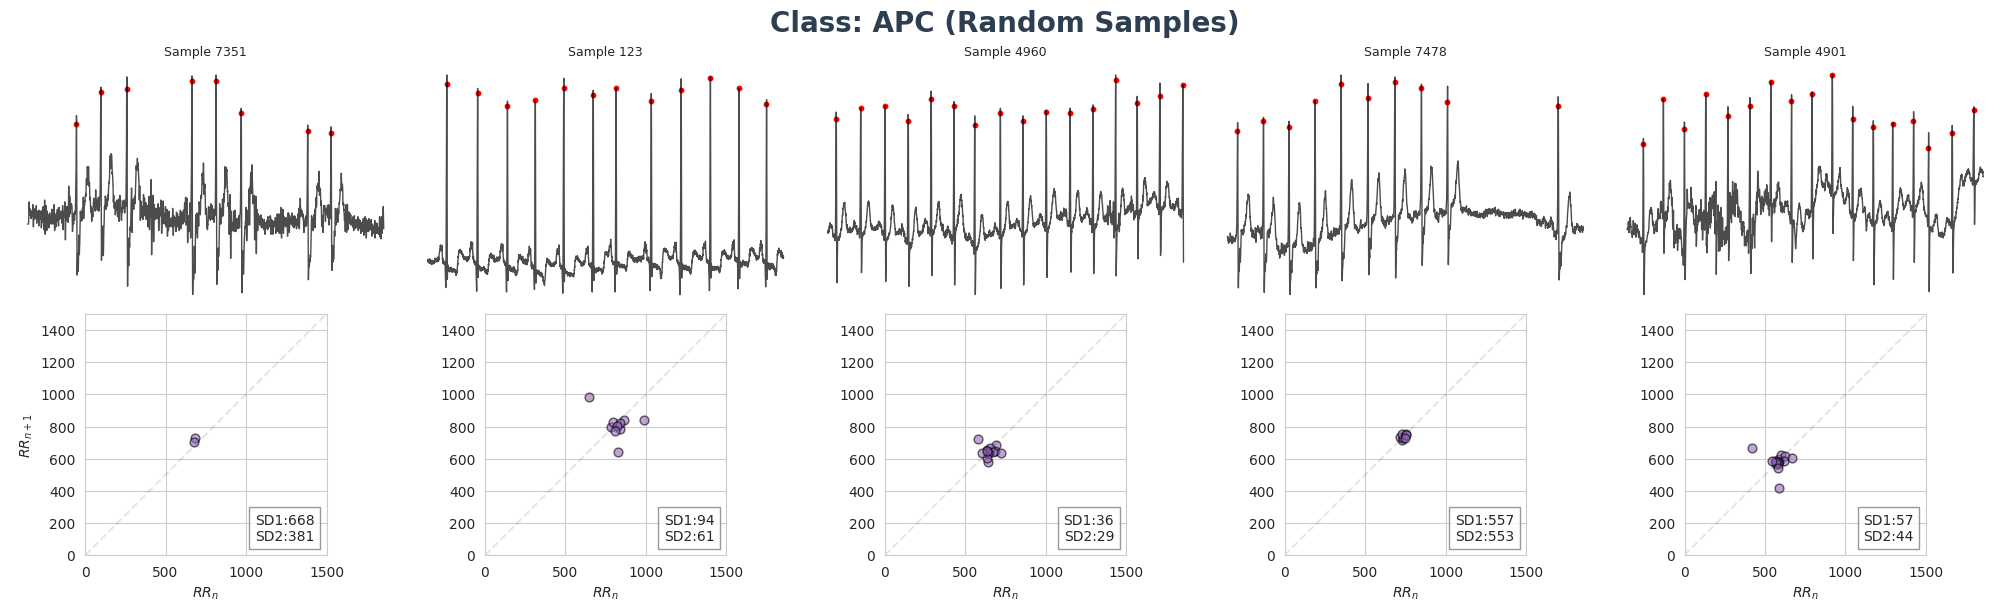

In [15]:
# @title The Chaos Gallery: 5 Classes x 5 Random Examples (Consistent)
def plot_chaos_gallery():
    # Setup
    classes_to_plot = [0, 1, 2, 3, 4] # N, L, R, V, A
    n_examples = 5
    engineer = HeartEngineer()

    manual_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for class_id in classes_to_plot:
        class_name = CLASS_NAMES[class_id]
        indices = np.where(y_mc == class_id)[0]

        if len(indices) < n_examples:
            current_n = len(indices)
            sampled_idx = indices
        else:
            current_n = n_examples
            sampled_idx = np.random.choice(indices, current_n, replace=False)

        fig = plt.figure(figsize=(20, 6), constrained_layout=True)
        subfigs = fig.subfigures(1, 1)
        subfigs.suptitle(f"Class: {class_name} (Random Samples)", fontsize=20, fontweight='bold', color='#2c3e50')

        axs = subfigs.subplots(2, current_n)
        if current_n == 1: axs = axs.reshape(2, 1)

        for i, idx in enumerate(sampled_idx):
            # 1. Get Data
            raw_window = X_cnn_mc[idx].flatten()

            # 2. Process - CRITICAL FIX: Use Robust Detector
            peaks = engineer.pan_tompkins_detector(raw_window)

            # 3. Plot Signal (Top Row)
            ax_sig = axs[0, i]
            ax_sig.plot(raw_window, color='black', alpha=0.7, linewidth=1)
            ax_sig.scatter(peaks, raw_window[peaks], c='red', s=10) # Mark peaks
            ax_sig.set_title(f"Sample {idx}", fontsize=9)
            ax_sig.axis('off')

            # 4. Plot Poincare (Bottom Row)
            ax_poin = axs[1, i]

            if len(peaks) > 2:
                rr = np.diff(peaks) / Config.FS * 1000
                x, y = rr[:-1], rr[1:]
                color = manual_colors[class_id]

                ax_poin.scatter(x, y, c=color, alpha=0.6, edgecolors='k', s=40)
                lims = [0, 1500]
                ax_poin.plot(lims, lims, 'k--', alpha=0.1)
                ax_poin.set_xlim(lims)
                ax_poin.set_ylim(lims)

                sd1 = np.std(np.subtract(x, y) / np.sqrt(2))
                sd2 = np.std(np.add(x, y) / np.sqrt(2))
                ax_poin.text(0.95, 0.05, f"SD1:{sd1:.0f}\nSD2:{sd2:.0f}",
                             transform=ax_poin.transAxes, ha='right', va='bottom', fontsize=10,
                             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
            else:
                ax_poin.text(0.5, 0.5, "Not enough peaks", ha='center')

            ax_poin.set_aspect('equal')
            ax_poin.set_xlabel("$RR_n$")
            if i == 0: ax_poin.set_ylabel("$RR_{n+1}$")

        plt.show()

print("Generating Chaos Gallery (Fixed & Consistent)...")
plot_chaos_gallery()